In [1]:
import sys
print(sys.version)

3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

State: x [m], y [m], yaw [rad], velocity [m/s]

\begin{align}
\textbf{x}_t &=
\begin{bmatrix}
    x_t \\
    y_t \\
    \theta_t \\
    v_t \\
\end{bmatrix}
\end{align}

Input: velocity [m/s], yaw rate [rad/s]

\begin{align}
\textbf{u}_t &=
\begin{bmatrix}
    v_t \\
    \omega_t \\
\end{bmatrix}
\end{align}

Observation: x [m], y [m]

\begin{align}
\textbf{z}_t &=
\begin{bmatrix}
    x_t \\
    y_t \\
\end{bmatrix}
\end{align}

# Parameters

In [3]:
DELTA_TIME = 0.1 # [s]
END_TIME = 30.0 # [s]

INPUT_COV = np.diag([
    1.0**2, # [m^2/s^2] variance of velocity input
    np.deg2rad(30.0)**2 # [rad^2/s^2] variance of yaw rate input
])

GNSS_COV = np.diag([
    0.5**2, # [m^2] variance of x reading
    0.5**2 # [m^2] variance of y reading
])

In [4]:
### Process noise covariance
Q = np.diag([
    0.1**2, # [m^2] variance of x
    0.1**2, # [m^2] variance of y
    np.deg2rad(1.0)**2, # [rad^2] variance of yaw
    1.0**2 # [m^2/s^2] variance of velocity
])

### Observation noise covariance
R = np.diag([
    1.0**2, # [m^2] variance of x
    1.0**2 # [m^2] variance of y
])

# Functions

In [5]:
def MotionModel(x_prev, u_curr):
    yaw_prev = x_prev[2, 0]
    
    F = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]
    ])

    B = np.array([
        [DELTA_TIME*math.cos(yaw_prev), 0],
        [DELTA_TIME*math.sin(yaw_prev), 0],
        [0, DELTA_TIME],
        [1, 0]
    ])

    x_curr = F@x_prev + B@u_curr

    return x_curr



def JacobF(yaw, v):
    J_F = np.array([
        [1, 0, -v*DELTA_TIME*math.sin(yaw), DELTA_TIME*math.cos(yaw)],
        [0, 1, v*DELTA_TIME*math.cos(yaw), DELTA_TIME*math.sin(yaw)],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return J_F

In [6]:
def ObservationModel(x_curr):
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z_curr = H@x_curr

    return z_curr



def JacobH():
    J_H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    return J_H

In [7]:
def MotionPredict(x_prev_post, u_curr_noisy, P_prev_post):
    yaw = x_prev_post[2, 0] # [rad]
    v = u_curr_noisy[0, 0] # [m/s]
    J_F = JacobF(yaw, v)

    x_curr_prior = MotionModel(x_prev_post, u_curr_noisy)
    P_curr_prior = J_F@P_prev_post@J_F.T + Q

    return x_curr_prior, P_curr_prior



def MeasurementUpdate(x_curr_prior, P_curr_prior, z_curr):
    J_H = JacobH()

    obs_res = z_curr - ObservationModel(x_curr_prior) ### Observation residual (Innovation)
    S = J_H@P_curr_prior@J_H.T + R ### Observation residual covariance (Innovation covariance)
    K = (P_curr_prior@J_H.T)@np.linalg.inv(S) ### Kalman gain

    x_curr_post = x_curr_prior + K@obs_res
    P_curr_post = (np.eye(len(x_curr_post)) - K@J_H)@P_curr_prior
   
    return x_curr_post, P_curr_post



def ExtendedKalmanFilter(x_prev_post, P_prev_post, u_curr_noisy, z_curr):
    x_curr_prior, P_curr_prior = MotionPredict(x_prev_post, u_curr_noisy, P_prev_post)
    x_curr_post, P_curr_post = MeasurementUpdate(x_curr_prior, P_curr_prior, z_curr)

    return x_curr_post, P_curr_post

In [8]:
def Vizualize(xs_GT, xs_DR, xs_est, zs, min_x, max_x, tick_x, min_y, max_y, tick_y):
    xs_GT_np = np.array(xs_GT)
    xs_DR_np = np.array(xs_DR)
    xs_est_np = np.array(xs_est)
    zs_np = np.array(zs)

    plt.plot(xs_GT_np[:, 0], xs_GT_np[:, 1], color='blue')
    plt.plot(xs_DR_np[:, 0], xs_DR_np[:, 1], color='black')
    plt.plot(xs_est_np[:, 0], xs_est_np[:, 1], color='red', linestyle='dashed')
    plt.scatter(zs_np[:, 0], zs_np[:, 1], color='green', s=2)

    plt.xticks(np.arange(2*min_x, 2*max_x, tick_x))
    plt.yticks(np.arange(2*min_y, 2*max_y, tick_y))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.grid(True)

    return

# Initialize

In [9]:
t = 0.0

x_GT_init = np.zeros((4, 1)) ### Ground Truth
x_DR_init = np.zeros((4, 1)) ### Dead Reckoning

x_est_init = np.zeros((4, 1))
P_est_init = np.diag([
    1.0**2, # [m^2] variance of x
    1.0**2, # [m^2] variance of y
    1.0**2, # [rad^2] variance of yaw
    1.0**2 # [m^2/s^2] variance of velocity
])

In [10]:
xs_GT = [x_GT_init]
xs_DR = [x_DR_init]
xs_est = [x_est_init]
zs = [np.zeros((2, 1))]

# Main loop

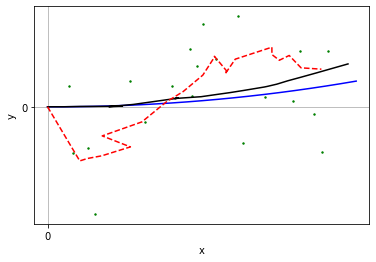

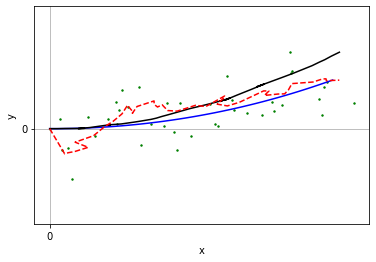

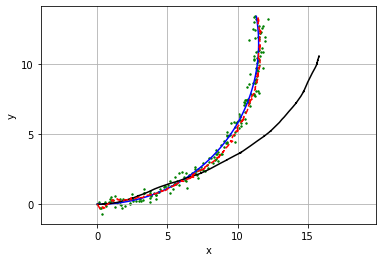

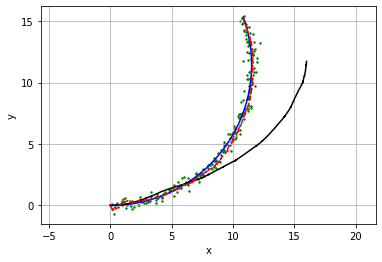

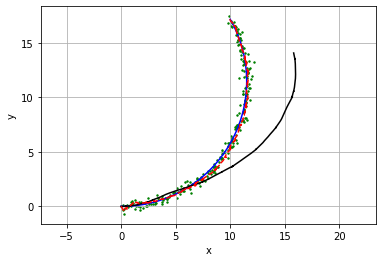

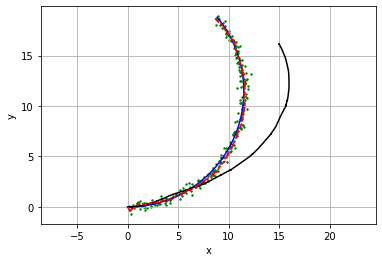

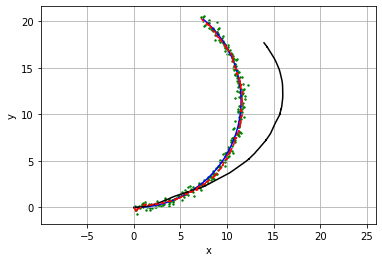

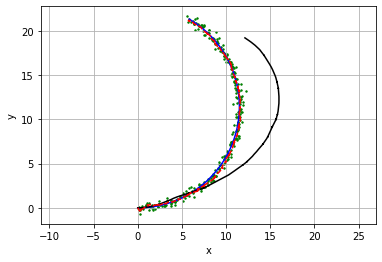

In [11]:
x_GT_prev = x_GT_init
x_DR_prev = x_DR_init
x_est_prev = x_est_init
P_est_prev = P_est_init

while t < END_TIME:
    ### Input command ... NOTE: "u_curr.shape" must be (2, 1), not (2,)
    v = 1.0 # [m/s]
    omega = np.deg2rad(5.0) # [m/s]
    u_curr = np.array([
        [v],
        [omega],
    ])
    
    ### Ground Truth state
    x_GT_curr = MotionModel(x_GT_prev, u_curr)

    ### Dead Reckoning state
    input_noise = INPUT_COV @ np.random.randn(2, 1)
    u_curr_noisy = u_curr + input_noise
    x_DR_curr = MotionModel(x_DR_prev, u_curr_noisy)

    ### Observation
    gnss_noise = GNSS_COV @ np.random.randn(2, 1)
    z_curr = ObservationModel(x_GT_curr) + gnss_noise

    ### Extended Kalman Filter estimation
    x_est_curr, P_est_curr = ExtendedKalmanFilter(x_est_prev, P_est_prev, u_curr_noisy, z_curr)

    xs_GT.append(x_GT_curr)
    xs_DR.append(x_DR_curr)
    xs_est.append(x_est_curr)
    zs.append(z_curr)

    if np.isclose((t + DELTA_TIME) % 2.0, 0.0, atol=1.0e-5):
        min_x, max_x, tick_x = -15, 15, 5
        min_y, max_y, tick_y = -5, 25, 5
        Vizualize(xs_GT, xs_DR, xs_est, zs, min_x, max_x, tick_x, min_y, max_y, tick_y)
        plt.pause(0.001)

    x_GT_prev = x_GT_curr
    x_DR_prev = x_DR_curr
    x_est_prev = x_est_curr
    P_est_prev = P_est_curr

    t += DELTA_TIME